In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [3]:
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.anBiGLasso_cov import anBiGLasso
from Scripts.EiGLasso import EiGLasso_cov as EiGLasso
from Scripts.scBiGLasso import scBiGLasso_cov as scBiGLasso
from Scripts.utilities import binarize_matrix

In [4]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# COIL Data
From the 'processed' dataset available here: https://cave.cs.columbia.edu/repository/COIL-20

We only look at the duck data.

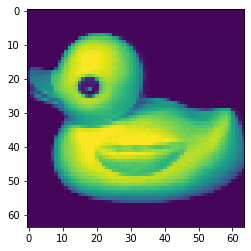

In [191]:
# Here we load the image, and optionally drop every `imsize_factor`th pixel
# if we want to minimize pixels.  In the BiGLasso paper, they considered 9 by 9
# We consider the 64x64 case
import glob
imsize_factor = 2
imsize = 128 // imsize_factor
files = sorted(glob.glob('../../Data/coil-20-proc/*.png'))
duck_mat = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize**2))
duck_mat.shape # object, frame, flattened pixel
plt.imshow(duck_mat[10, 0].reshape(imsize, imsize))

In [192]:
T, S = nonparanormal_skeptic(duck_mat[10][np.newaxis, ...]) 

In [16]:
from Scripts.anBiGLasso import calculateEigenvalues, eigenvectors_MLE
from Scripts.anBiGLasso_cov import eigenvalues_MLE
# Runtime analysis
%lprun -f anBiGLasso -f calculateEigenvalues -f eigenvalues_MLE -f eigenvectors_MLE \
    anBiGLasso(T, S, beta_1 = 0.002, beta_2 = 0.002)

In [213]:
Psi, Theta = anBiGLasso(T, S, beta_1 = 0.07, beta_2 = 0.5, B_approx_iters = 10)
"""
from scipy.stats import norm
Psi, Theta = raw_anBiGLasso(
    duck_mat[10][np.newaxis, ...],
    beta_1 = 1e25,
    beta_2 = 0.002,
    B_approx_iters = 1000
)
print(Psi)
"""
print(Psi)

[[-0.252 -0.251  0.    ... -0.252  0.     0.   ]
 [-0.251 -0.313  0.    ... -0.041  0.    -0.   ]
 [ 0.     0.    -0.083 ...  0.    -0.    -0.434]
 ...
 [-0.252 -0.041  0.    ... -0.119  0.     0.   ]
 [ 0.     0.    -0.    ...  0.    -0.07  -0.514]
 [ 0.    -0.    -0.434 ...  0.    -0.514 -0.021]]


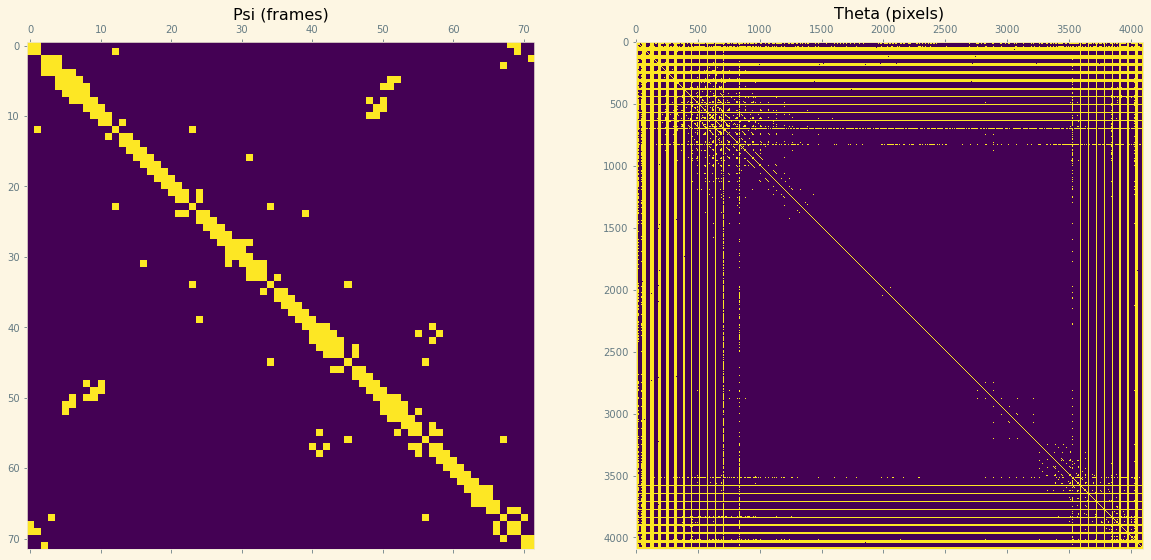

In [214]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')
    
    # Add gridlines for pixel rows
    # We skip rows b/c otherwise it would be too cluttered
    #for i in range(16):
    #    ax2.axvline(64*i)
    #    ax2.axhline(64*i)
    #fig.savefig('../../Plots/Duck/anBiGLasso Performance.png')

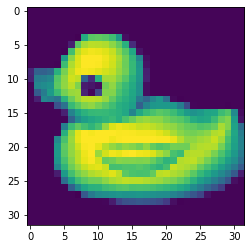

In [120]:
duck_mat_ = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize, imsize))[10]
plt.imshow(duck_mat_[0])

In [159]:
Psi, Theta = raw_anBiGLasso(
    duck_mat_,
    beta_1 = 0.0001,
    beta_2 = 0.0002,
    B_approx_iters = -1
)
Psi *= 10000
Theta *= 10000

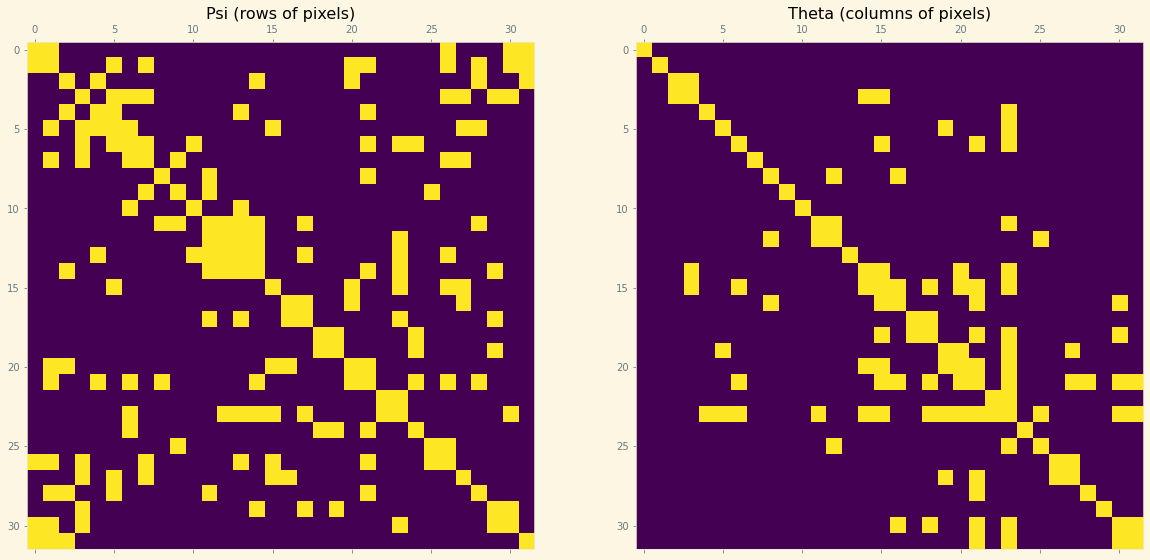

In [160]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (rows of pixels)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (columns of pixels)')